# PS2 Econ 571 

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn
import math
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller # Dickey-Fuller test
from statsmodels.tsa.statespace.tools import diff # difference operator 
%matplotlib inline

In [5]:
gdp_df = pd.read_csv("./data/USGDP.csv")
money_df = pd.read_csv("./data/USMoney.csv")
print("gdp:" + str(gdp_df.shape) + " money:" + str(money_df.shape)) 

gdp:(283, 4) money:(708, 5)


In [6]:
gdp_df.GDP = gdp_df.GDP.apply(lambda x: float(x.replace(',','')))

In [7]:
# transform months to quarters and average the data
amoney_df = money_df.groupby(money_df.index // 3, ).mean()
amoney_df.Month = (amoney_df.index % 4) + 1
amoney_df = amoney_df.rename(columns={'Month':'Quarter'})

In [8]:
gdp_cols = ['Year', 'Quarter', 'GDP']
amoney_df = pd.merge(amoney_df, gdp_df[['Year', 'Quarter', 'GDP', 'GDPDEF']], on=['Year', 'Quarter'], how='inner')

In [9]:
# adjust for inflation using GDP deflator. 
amoney_df.M1 = (amoney_df.M1 / amoney_df.GDPDEF) * 100
amoney_df.M2 = (amoney_df.M2 / amoney_df.GDPDEF) * 100
amoney_df.GDP = ((amoney_df.GDP / amoney_df.GDPDEF) * 100)
amoney_df = amoney_df.rename(columns={'GDP':'RGDP'})

In [10]:
# create an annual version of the data. 
qmoney_df = amoney_df  # quarters
ymoney_df = amoney_df.head(232).groupby(amoney_df.head(232).index // 4, ).mean()
ymoney_df.Year =  ymoney_df.Year.astype(int)
ymoney_df.shape

(58, 7)

In [11]:
# quarterly train and test. 
qm1 = np.log(qmoney_df.M1) / np.log(math.e)
qm2 = np.log(qmoney_df.M2) / np.log(math.e)
qx = qmoney_df.drop(['M1', 'M2', 'Year', 'Quarter', 'GDPDEF'], axis=1)
qx = np.log(qx) / np.log(math.e)
#qx = sm.add_constant(qx)  # add a column of ones. 

#yearly train and test
ym1 = np.log(ymoney_df.M1) / np.log(math.e)
ym2 = np.log(ymoney_df.M2) / np.log(math.e)
yx = ymoney_df.drop(['M1', 'M2', 'Year', 'Quarter', 'GDPDEF'], axis=1)
yx = np.log(yx) / np.log(math.e)
#yx = sm.add_constant(yx)

# Quarterly 

## Verifying first order stationarity on quarterly $ln(RGDP)$ 

### First plot the no difference rolling stats

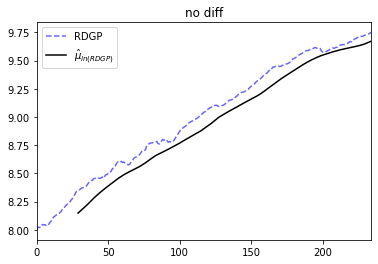

In [13]:
qx.RGDP.plot(style='k--', c='b', alpha=0.6)
ax = qx.RGDP.rolling(30).mean().plot(style='k', title="no diff")
ax.legend(['RDGP', r'$\hat{\mu}_{ln(RDGP)}$'])
#ax.get_figure().savefig('figures/stationary_diff/m_0diff.pdf')

$\hat{\mu}_{ln(RDGP)}$ is non stationary with no difference

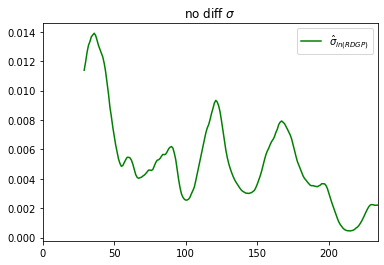

In [14]:
ax = qx.RGDP.rolling(30).var().plot(style='g', title=r'no diff $\sigma$')
ax.legend([r'$\hat{\sigma}_{ln(RDGP)}$'])
#ax.get_figure().savefig('figures/stationary_diff/s_0diff.pdf')

### Now plot rolling $\hat{\mu}_{ln(RDGP)}$ and $\hat{\sigma}_{ln(RDGP)}$ of the first difference

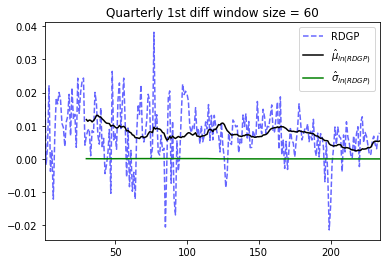

In [15]:
diff1 = diff(qx.RGDP, k_diff=1)
diff1.plot(style='k--', c='b', alpha=0.6)
ax = diff1.rolling(30).mean().plot( style='k', legend=True, title=r'1st diff window size = 60')
ax = diff1.rolling(30).var().plot( style='g', legend=True, title=r'Quarterly 1st diff window size = 60')
ax.legend(['RDGP', r'$\hat{\mu}_{ln(RDGP)}$', r'$\hat{\sigma}_{ln(RDGP)}$'])
#ax.get_figure().savefig('figures/stationary_diff/sm_1diff.pdf')

Inspecting the graph, first difference is a fairly stationary process

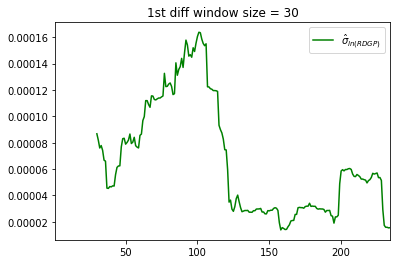

In [16]:
ax = diff1.rolling(30).var().plot( style='g', legend=True, title=r'1st diff window size = 30')
ax.legend([r'$\hat{\sigma}_{ln(RDGP)}$'])
#ax.get_figure().savefig('figures/stationary_diff/s_1diff.pdf')

## Dickey-Fuller test on $ln(RGDP)$

In [12]:
# Prefrom the Dickey-Fuller test on ln(RGDP)
# this loop will automatically choose the correct number of difference
i = 0
result = None
while True: 
    q_X_d = diff(qx.RGDP, k_diff=i)
    result = adfuller(q_X_d, regression='c')
    print("-------------------------------")
    print(str(i) + "th degree difference")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('used lags: %f' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("-------------------------------")
    if result[1] < 0.05: 
        break
    i += 1

-------------------------------
0th degree difference
ADF Statistic: -2.188110
p-value: 0.210589
used lags: 2.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
-------------------------------
-------------------------------
1th degree difference
ADF Statistic: -7.464437
p-value: 0.000000
used lags: 1.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
-------------------------------


## ACF and PCAF for first diff on quarterly $ln(RGDP)$

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

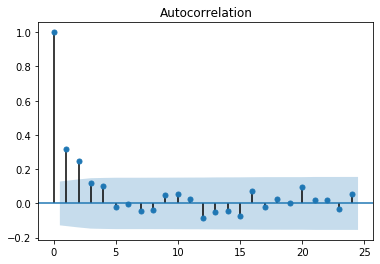

In [18]:
fig = plot_acf(diff1)
fig.savefig("figures/acf.pdf")

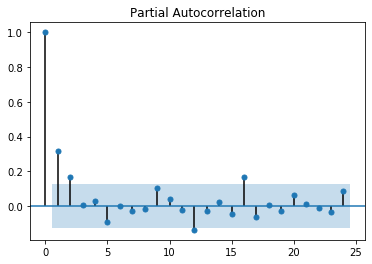

In [19]:
_ = plot_pacf(diff1).savefig("figures/pacf.pdf")

### looks like both cut off at 2nd lag, will use ARIMA(2, 1, 2)

In [20]:
from statsmodels.tsa.arima_model import ARIMA

## quarterly $ln(RGDP)$ arima(2,1,2)

In [21]:
qM2Arima = ARIMA(qx.RGDP, order=(2,1,2))
qm2ArimaResults = qM2Arima.fit()
print(qm2ArimaResults.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.RGDP   No. Observations:                  234
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 805.295
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sat, 22 Feb 2020   AIC                          -1598.590
Time:                        10:36:01   BIC                          -1577.858
Sample:                             1   HQIC                         -1590.231
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0075      0.001      8.403      0.000       0.006       0.009
ar.L1.D.RGDP    -0.1683      0.331     -0.509      0.611      -0.816       0.480
ar.L2.D.RGDP     0.4651      0.258      1.80

## Testing Rolling $\mu$ and $\sigma$ on differences in $ln(RM1)$

In [90]:
dqm1 = diff(qm1, k_diff=1) # first diff

In [91]:
dqm2 = diff(qm1, k_diff=2) # second diff

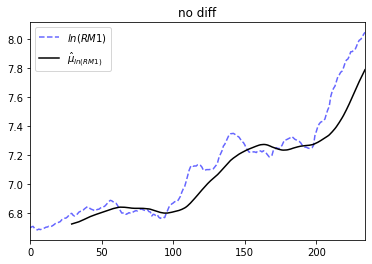

In [27]:
qm1.plot(style='k--', c='b', alpha=0.6)
ax = qm1.rolling(30).mean().plot(style='k', title="no diff")
ax.legend([r'$ln(RM1)$', r'$\hat{\mu}_{ln(RM1)}$'])
#ax.get_figure().savefig('figures/stationary_diff/m_0diff.pdf')
ax.get_figure().savefig('figures/stationary_diff/qm10_mu.pdf')

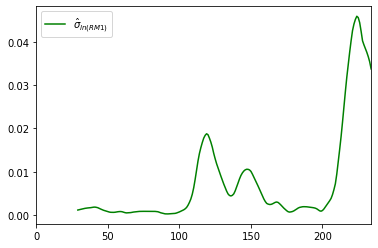

In [28]:
ax = qm1.rolling(30).var().plot(style='g')
ax.legend([r'$\hat{\sigma}_{ln(RM1)}$'])
#ax.get_figure().savefig('figures/stationary_diff/qm10_v.pdf')

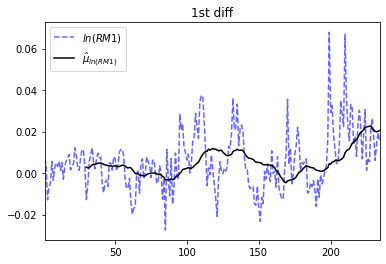

In [29]:
dqm1.plot(style='k--', c='b', alpha=0.6)
ax = dqm1.rolling(30).mean().plot(style='k', title="1st diff")
ax.legend([r'$ln(RM1)$', r'$\hat{\mu}_{ln(RM1)}$'])
ax.get_figure().savefig('figures/stationary_diff/qm11_mu.pdf')

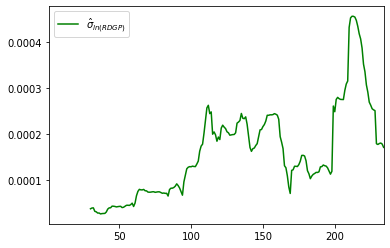

In [30]:
ax = dqm1.rolling(30).var().plot(style='g')
ax.legend([r'$\hat{\sigma}_{ln(RDGP)}$'])
ax.get_figure().savefig('figures/stationary_diff/qm11_v.pdf')

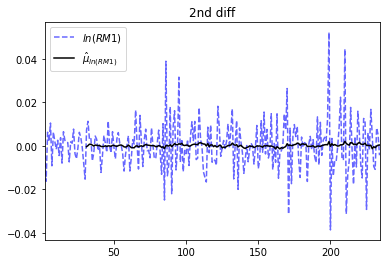

In [31]:
dqm2.plot(style='k--', c='b', alpha=0.6)
ax = dqm2.rolling(30).mean().plot(style='k', title="2nd diff")
ax.legend([r'$ln(RM1)$', r'$\hat{\mu}_{ln(RM1)}$'])
#ax.get_figure().savefig('figures/stationary_diff/m_0diff.pdf')
ax.get_figure().savefig('figures/stationary_diff/qm12_mu.pdf')

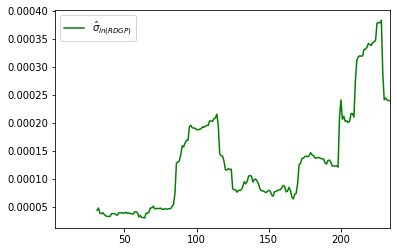

In [32]:
ax = dqm2.rolling(30).var().plot(style='g')
ax.legend([r'$\hat{\sigma}_{ln(RDGP)}$'])
ax.get_figure().savefig('figures/stationary_diff/qm12_v.pdf')

## Dickey-Fuller test on quarterly $ln(RM1)$ 2nd diff

In [33]:
result = adfuller(dqm2, regression='c')
print("-------------------------------")
print("2nd degree difference")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('used lags: %f' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

-------------------------------
2nd degree difference
ADF Statistic: -10.526648
p-value: 0.000000
used lags: 3.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


## PACF and ACF on 2nd diff $ln(RM1)$

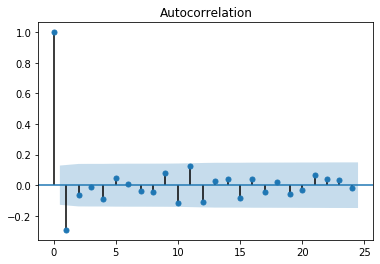

In [88]:
fig = plot_acf(dqm2).savefig('figures/qm1acf.pdf')

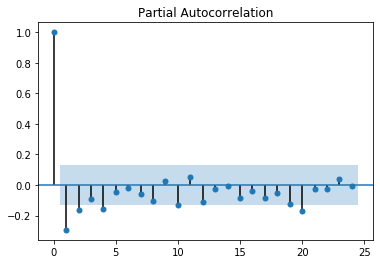

In [89]:
fig = plot_pacf(dqm2).savefig('figures/qm1pacf.pdf')

## $ln(RM1)$ arima (2,2,1)

In [39]:
dgdp2 = diff(qx.RGDP, k_diff=2)
dr2 = diff(qx.TB3MS, k_diff=2)
dqx2 = pd.DataFrame({'RGDP': dgdp2, 'TB3MS': dr2 })
dqm12 = diff(qm1, k_diff=2)
qM1Arima = ARIMA(dqm12.reset_index(drop=True), order=(2,0,1), exog=dqx2.reset_index(drop=True))
qM1ArimaResults = qM1Arima.fit(maxiter=500)
print(qM1ArimaResults.summary())

                              ARMA Model Results                              
Dep. Variable:                     M1   No. Observations:                  233
Model:                     ARMA(2, 1)   Log Likelihood                 743.333
Method:                       css-mle   S.D. of innovations              0.010
Date:                Sat, 22 Feb 2020   AIC                          -1472.667
Time:                        10:38:10   BIC                          -1448.509
Sample:                             0   HQIC                         -1462.925
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.786e-05   3.13e-05      1.850      0.064   -3.43e-06       0.000
RGDP           0.0247      0.081      0.304      0.761      -0.134       0.184
TB3MS         -0.0069      0.002     -2.768      0.0

In [40]:
qM1ArimaResults.cov_params()#.to_csv('results/qm1arima.csv')

,const,RGDP,TB3MS,ar.L1.M1,ar.L2.M1,ma.L1.M1
const,9.778620e-10,1.796029e-07,-3.221702e-10,-1.569785e-08,-2.992649e-09,3.519216e-10
RGDP,1.796029e-07,6.576947e-03,-2.181423e-05,-2.317121e-04,4.534484e-06,9.215690e-08
TB3MS,-3.221702e-10,-2.181423e-05,6.241169e-06,4.060820e-05,-4.004271e-05,-3.279040e-09
ar.L1.M1,-1.569785e-08,-2.317121e-04,4.060820e-05,4.412525e-03,-2.839304e-03,-5.312031e-07
ar.L2.M1,-2.992649e-09,4.534484e-06,-4.004271e-05,-2.839304e-03,4.412672e-03,-4.292405e-07
ma.L1.M1,3.519216e-10,9.215690e-08,-3.279040e-09,-5.312031e-07,-4.292405e-07,2.029409e-04


## HAC robust ln(M1) estimate

In [41]:
print(sm.OLS(qm1, sm.add_constant(qx), cov_type='HAC').fit().summary())

                            OLS Regression Results                            
Dep. Variable:                     M1   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     943.3
Date:                Sat, 22 Feb 2020   Prob (F-statistic):          3.74e-112
Time:                        10:38:36   Log-Likelihood:                 177.12
No. Observations:                 235   AIC:                            -348.2
Df Residuals:                     232   BIC:                            -337.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0623      0.158     19.333      0.0

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Yearly

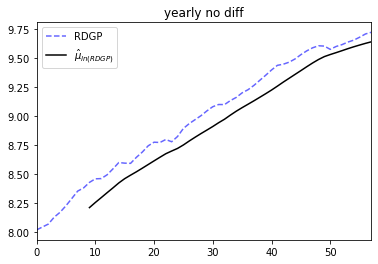

In [61]:
yx.RGDP.plot(style='k--', c='b', alpha=0.6)
ax = yx.RGDP.rolling(10).mean().plot(style='k', title="yearly no diff")
ax.legend(['RDGP', r'$\hat{\mu}_{ln(RDGP)}$'])
ax.get_figure().savefig('figures/stationary_diff/ym_0diff.pdf')

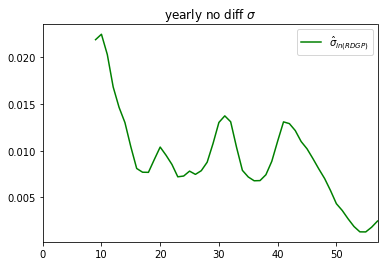

In [62]:
ax = yx.RGDP.rolling(10).var().plot(style='g', title=r'yearly no diff $\sigma$')
ax.legend([r'$\hat{\sigma}_{ln(RDGP)}$'])
#ax.get_figure().savefig('figures/stationary_diff/s_0diff.pdf')

In [42]:
# Prefrom the Dickey-Fuller test on ln(RGDP)
# this loop will automatically choose the correct number of difference
i = 0
result = None
while True: 
    y_X_d = diff(yx.RGDP, k_diff=i)
    result = adfuller(y_X_d, regression='c')
    print("-------------------------------")
    print(str(i) + "th degree difference")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('used lags: %f' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("-------------------------------")
    if result[1] < 0.05: 
        break
    i += 1

-------------------------------
0th degree difference
ADF Statistic: -2.733411
p-value: 0.068433
used lags: 2.000000
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596
-------------------------------
-------------------------------
1th degree difference
ADF Statistic: -5.151959
p-value: 0.000011
used lags: 0.000000
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
-------------------------------


In [53]:
ygdp = diff(yx.RGDP, k_diff=1)

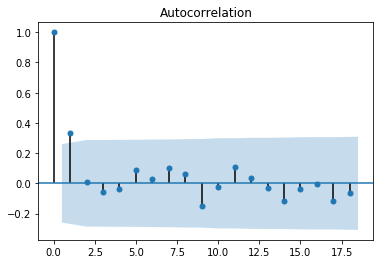

In [54]:
_ = plot_acf(ygdp).savefig("figures/acf_ygdp.pdf")

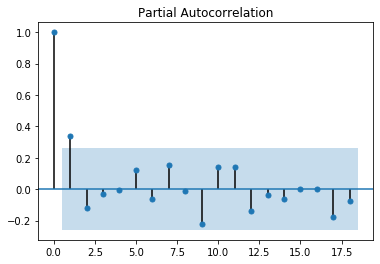

In [55]:
_ = plot_pacf(ygdp).savefig("figures/pacf_ygdp.pdf")

In [56]:
ygdpArima = ARIMA(yx.RGDP, order=(1,1,1))
ygdpArimaResults = ygdpArima.fit()
print(ygdpArimaResults.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.RGDP   No. Observations:                   57
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 145.016
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 22 Feb 2020   AIC                           -282.032
Time:                        10:43:38   BIC                           -273.860
Sample:                             1   HQIC                          -278.856
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0298      0.004      8.517      0.000       0.023       0.037
ar.L1.D.RGDP     0.0839      0.379      0.222      0.825      -0.658       0.826
ma.L1.D.RGDP     0.2832      0.367      0.77

## Dickey-Fuller test on yearly $ln(M1)$

In [57]:
# Prefrom the Dickey-Fuller test on 
# this loop will automatically choose the correct number of difference
i = 0
result = None
while True: 
    y_X_d = diff(ym1, k_diff=i)
    result = adfuller(y_X_d, regression='c')
    print("-------------------------------")
    print(str(i) + "th degree difference")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('used lags: %f' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("-------------------------------")
    if result[1] < 0.05: 
        break
    i += 1

-------------------------------
0th degree difference
ADF Statistic: 1.130393
p-value: 0.995468
used lags: 2.000000
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596
-------------------------------
-------------------------------
1th degree difference
ADF Statistic: -3.809008
p-value: 0.002816
used lags: 1.000000
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596
-------------------------------


In [77]:
ym11 = diff(ym1, k_diff=1)

## PACF and ACF for first diff $ln(RM1)$

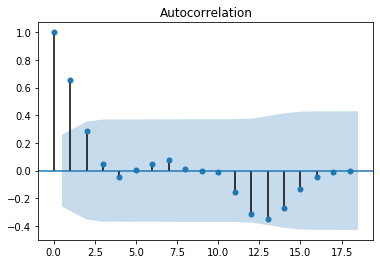

In [78]:
_ = plot_acf(ym11).savefig("figures/acf_y.pdf")

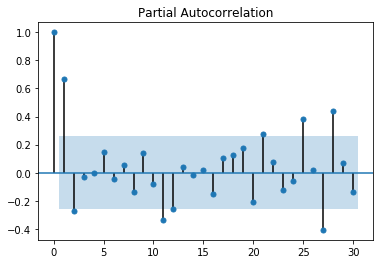

In [79]:
_ = plot_pacf(ym11, lags=30).savefig("figures/pacf_y.pdf")

In [376]:
y_X.shape

(58, 3)

In [377]:
q_X.shape

(235, 3)

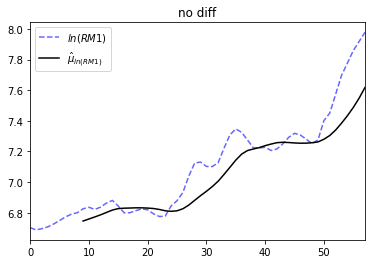

In [65]:
ym1.plot(style='k--', c='b', alpha=0.6)
ax = ym1.rolling(10).mean().plot(style='k', title="no diff")
ax.legend([r'$ln(RM1)$', r'$\hat{\mu}_{ln(RM1)}$'])
#ax.get_figure().savefig('figures/stationary_diff/m_0diff.pdf')
ax.get_figure().savefig('figures/stationary_diff/ym10_mu.pdf')

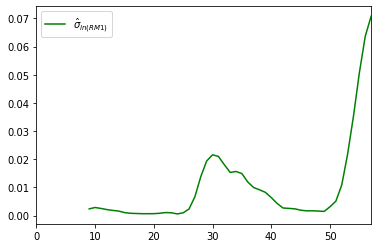

In [66]:
ax = ym1.rolling(10).var().plot(style='g')
ax.legend([r'$\hat{\sigma}_{ln(RM1)}$'])
ax.get_figure().savefig('figures/stationary_diff/ym10_v.pdf')

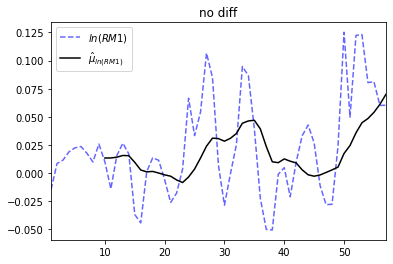

In [69]:
ym11.plot(style='k--', c='b', alpha=0.6)
ax = ym11.rolling(10).mean().plot(style='k', title="no diff")
ax.legend([r'$ln(RM1)$', r'$\hat{\mu}_{ln(RM1)}$'])
#ax.get_figure().savefig('figures/stationary_diff/m_0diff.pdf')
ax.get_figure().savefig('figures/stationary_diff/ym11_mu.pdf')

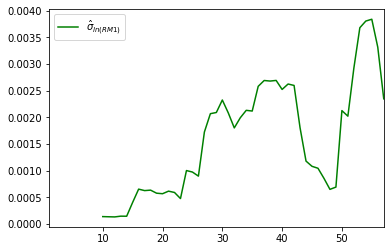

In [70]:
ax = ym11.rolling(10).var().plot(style='g')
ax.legend([r'$\hat{\sigma}_{ln(RM1)}$'])
ax.get_figure().savefig('figures/stationary_diff/ym11_v.pdf')

In [71]:
ym12 = diff(ym1, k_diff=2)

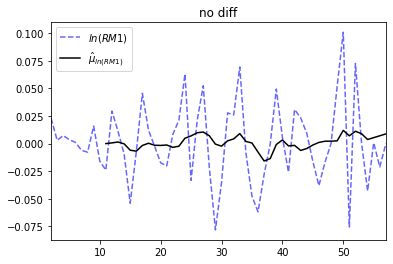

In [72]:
ym12.plot(style='k--', c='b', alpha=0.6)
ax = ym12.rolling(10).mean().plot(style='k', title="no diff")
ax.legend([r'$ln(RM1)$', r'$\hat{\mu}_{ln(RM1)}$'])
#ax.get_figure().savefig('figures/stationary_diff/m_0diff.pdf')
ax.get_figure().savefig('figures/stationary_diff/ym12_mu.pdf')

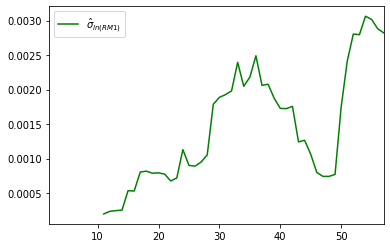

In [73]:
ax = ym12.rolling(10).var().plot(style='g')
ax.legend([r'$\hat{\sigma}_{ln(RM1)}$'])
ax.get_figure().savefig('figures/stationary_diff/ym12_v.pdf')

In [83]:
dym11 = diff(ym1, k_diff=1)
result = adfuller(dym11, regression='c')
print("-------------------------------")
print("2nd degree difference")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('used lags: %f' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

-------------------------------
2nd degree difference
ADF Statistic: -3.809008
p-value: 0.002816
used lags: 1.000000
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596


## First degree diff will be used, since p-value is suffiecently small and PACF/ACF graphs look well behaved under it

In [80]:
dgdp = diff(yx.RGDP, k_diff=1)
dr = diff(yx.TB3MS, k_diff=1)
del dqx2
dqx2 = pd.DataFrame({'RGDP': dgdp, 'TB3MS': dr })
del dqm12
dqm12 = diff(ym1, k_diff=1)
yM1Arima = ARIMA(dqm12.reset_index(drop=True), order=(2,0,1), exog=dqx2.reset_index(drop=True))
yM1ArimaResults = yM1Arima.fit(maxiter=500)
print(yM1ArimaResults.summary())

                              ARMA Model Results                              
Dep. Variable:                     M1   No. Observations:                   57
Model:                     ARMA(2, 1)   Log Likelihood                 126.646
Method:                       css-mle   S.D. of innovations              0.026
Date:                Sat, 22 Feb 2020   AIC                           -239.292
Time:                        10:53:23   BIC                           -224.991
Sample:                             0   HQIC                          -233.734
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0081      0.013      0.601      0.548      -0.018       0.034
RGDP           0.5137      0.150      3.423      0.001       0.220       0.808
TB3MS         -0.0384      0.006     -6.625      0.0

In [81]:
yM1ArimaResults.cov_params()

,const,RGDP,TB3MS,ar.L1.M1,ar.L2.M1,ma.L1.M1
const,0.000181,-0.000645,0.000014,-0.000121,0.000252,0.000020
RGDP,-0.000645,0.022529,-0.000555,0.007540,-0.004903,-0.000793
TB3MS,0.000014,-0.000555,0.000034,-0.000294,0.000188,-0.000069
ar.L1.M1,-0.000121,0.007540,-0.000294,0.031803,-0.016952,-0.007108
ar.L2.M1,0.000252,-0.004903,0.000188,-0.016952,0.029485,0.006837
ma.L1.M1,0.000020,-0.000793,-0.000069,-0.007108,0.006837,0.007262


## Yearly $ln(RM1)$ HAC robust estimate

In [82]:
print(sm.OLS(ym1, sm.add_constant(yx), cov_type='HAC').fit().summary())#.to_csv('results/ym1ols.csv')

                            OLS Regression Results                            
Dep. Variable:                     M1   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     288.1
Date:                Sat, 22 Feb 2020   Prob (F-statistic):           7.19e-30
Time:                        10:54:59   Log-Likelihood:                 52.860
No. Observations:                  58   AIC:                            -99.72
Df Residuals:                      55   BIC:                            -93.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2579      0.280     11.637      0.0

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [93]:
sm.OLS(ym1, sm.add_constant(yx), cov_type='HAC').fit().cov_params()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,TB3MS,RGDP
const,0.078379,-0.001637,-0.008524
TB3MS,-0.001637,0.000108,0.000170
RGDP,-0.008524,0.000170,0.000930
